In [175]:
import os
import numpy as np
import pandas as pd
import mysql.connector
import dotenv
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

In [176]:
dotenv.load_dotenv(
    os.path.join(os.path.dirname(os.path.dirname(os.path.abspath(""))), ".env")
)

db_config = {
    "host": os.getenv("MYSQL_HOST", "localhost"),
    "user": os.getenv("MYSQL_USER"),
    "password": os.getenv("MYSQL_PASSWORD"),
    "database": os.getenv("MYSQL_DATABASE"),
    "port": int(os.getenv("MYSQL_PORT", 3306)),
}

engine = create_engine(
    f"mysql+mysqlconnector://{os.getenv('MYSQL_USER')}:{os.getenv('MYSQL_PASSWORD')}@{os.getenv('MYSQL_HOST', 'localhost')}:{os.getenv('MYSQL_PORT', 3306)}/{os.getenv('MYSQL_DATABASE')}"
)

In [177]:
assignment_history_df = pd.read_sql("SELECT * FROM assignment_history", engine)
space_travel_agents_df = pd.read_sql("SELECT * FROM space_travel_agents", engine)
bookings_df = pd.read_sql("SELECT * FROM bookings", engine)

In [178]:
print(assignment_history_df.columns)
print(space_travel_agents_df.columns)
print(bookings_df.columns)

Index(['AssignmentID', 'AgentID', 'CustomerName', 'CommunicationMethod',
       'LeadSource', 'AssignedDateTime'],
      dtype='object')
Index(['AgentID', 'FirstName', 'LastName', 'Email', 'JobTitle',
       'DepartmentName', 'ManagerName', 'SpaceLicenseNumber', 'YearsOfService',
       'AverageCustomerServiceRating'],
      dtype='object')
Index(['BookingID', 'AssignmentID', 'BookingCompleteDate', 'CancelledDate',
       'Destination', 'Package', 'LaunchLocation', 'DestinationRevenue',
       'PackageRevenue', 'TotalRevenue', 'BookingStatus'],
      dtype='object')


Agent Completion Rate


In [179]:
merged_df = assignment_history_df.merge(bookings_df, on="AssignmentID", how="left")

completion_stats = merged_df.groupby("AgentID").agg(
    total_assignments=("AssignmentID", "count"),
    completed_bookings=("BookingCompleteDate", lambda x: x.notnull().sum()),
    total_revenue=("TotalRevenue", "sum"),
    destination_revenue=("DestinationRevenue", "sum"),
    package_revenue=("PackageRevenue", "sum"),
)
completion_stats["completion_rate"] = (
    completion_stats["completed_bookings"] / completion_stats["total_assignments"]
)

completion_stats = completion_stats.merge(
    space_travel_agents_df[["AgentID", "FirstName", "LastName"]], on="AgentID"
)
completion_stats["AgentName"] = (
    completion_stats["FirstName"] + " " + completion_stats["LastName"]
)

completion_stats_sorted = completion_stats[
    [
        "AgentName",
        "completion_rate",
        "total_revenue",
        "destination_revenue",
        "package_revenue",
    ]
].sort_values("completion_rate", ascending=False)
completion_stats_sorted

,AgentName,completion_rate,total_revenue,destination_revenue,package_revenue
9,Zara Khan,0.909091,1460000.0,1305000.0,155000.0
18,Calypso White,0.833333,2440000.0,2105000.0,335000.0
10,Elias Walker,0.812500,1970000.0,1695000.0,275000.0
16,Lyra Morgan,0.800000,2385000.0,2025000.0,360000.0
24,Enzo Nguyen,0.769231,1750000.0,1470000.0,280000.0
23,Phoebe Diaz,0.769231,1905000.0,1620000.0,285000.0
19,Orla Patel,0.769231,2020000.0,1710000.0,310000.0
26,Ronan Young,0.764706,2285000.0,1940000.0,345000.0
4,Vera Nguyen,0.733333,2220000.0,1880000.0,340000.0
5,Soren Baker,0.705882,2420000.0,2050000.0,370000.0


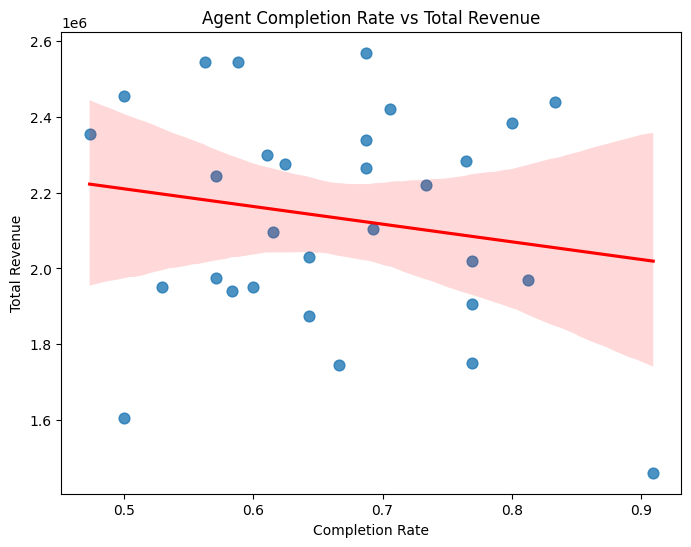

In [180]:
plt.figure(figsize=(8, 6))
sns.regplot(
    x=completion_stats_sorted["completion_rate"],
    y=completion_stats_sorted["total_revenue"],
    scatter_kws={"s": 60},
    line_kws={"color": "red"},
)
plt.xlabel("Completion Rate")
plt.ylabel("Total Revenue")
plt.title("Agent Completion Rate vs Total Revenue")
plt.show()

Elapsed Time by Agent


               AgentID  count      mean       std       min       25%  \
AgentName                                                               
Aurora Tanaka        1    9.0  0.425926  0.298853  0.166667  0.250000   
Kai Rodriguez        2    8.0  0.177083  0.457385 -0.583333  0.062500   
Nova Singh           3   11.0  0.325758  0.334279 -0.583333  0.250000   
Leo Kim              4    9.0  0.268519  0.353007 -0.583333  0.250000   
Vera Nguyen          5   11.0  0.409091  0.114592  0.250000  0.333333   
Soren Baker          6   12.0  0.388889  0.160229  0.166667  0.250000   
Mira Patel           7   11.0  0.507576  0.239949  0.250000  0.333333   
Orion Davis          8    8.0  0.312500  0.435867 -0.583333  0.187500   
Luna Martinez        9    9.0  0.222222  0.338502 -0.583333  0.250000   
Zara Khan           10   10.0  2.250000  5.770562  0.250000  0.333333   
Elias Walker        11   13.0  3.192308  6.903048 -0.583333  0.250000   
Nia Ramirez         12   11.0  0.348485  0.285818 -

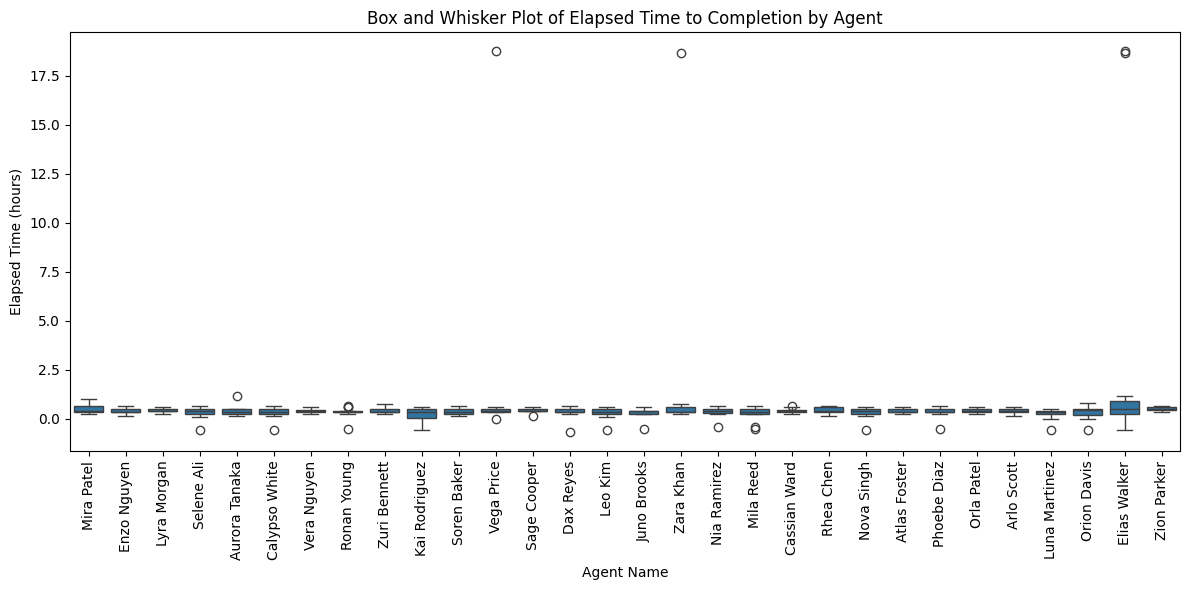

In [181]:
merged_df["AssignedDateTime"] = pd.to_datetime(merged_df["AssignedDateTime"])
merged_df["BookingCompleteDate"] = pd.to_datetime(merged_df["BookingCompleteDate"])
merged_df["elapsed_time_hours"] = (
    merged_df["BookingCompleteDate"] - merged_df["AssignedDateTime"]
).dt.total_seconds() / 3600

completed = merged_df[merged_df["BookingCompleteDate"].notnull()]

elapsed_summary = completed.groupby("AgentID")["elapsed_time_hours"].describe()
elapsed_summary = elapsed_summary.merge(
    space_travel_agents_df[["AgentID", "FirstName", "LastName"]], on="AgentID"
)
elapsed_summary["AgentName"] = (
    elapsed_summary["FirstName"] + " " + elapsed_summary["LastName"]
)
elapsed_summary = elapsed_summary.set_index("AgentName")
elapsed_summary.drop(columns=["FirstName", "LastName"], inplace=True)
print(elapsed_summary)

plt.figure(figsize=(12, 6))
sns.boxplot(
    x=completed["AgentID"].map(
        lambda aid: space_travel_agents_df.set_index("AgentID").loc[aid, "FirstName"]
        + " "
        + space_travel_agents_df.set_index("AgentID").loc[aid, "LastName"]
    ),
    y=completed["elapsed_time_hours"],
)
plt.xticks(rotation=90)
plt.xlabel("Agent Name")
plt.ylabel("Elapsed Time (hours)")
plt.title("Box and Whisker Plot of Elapsed Time to Completion by Agent")
plt.tight_layout()
plt.show()

Negative Elapsed Times?


In [182]:
negative_elapsed = completed[completed["elapsed_time_hours"] < 0]
print("Records with negative elapsed times:")
print(
    negative_elapsed[
        [
            "AssignmentID",
            "AgentID",
            "AssignedDateTime",
            "BookingCompleteDate",
            "elapsed_time_hours",
        ]
    ]
)

Records with negative elapsed times:
     AssignmentID  AgentID    AssignedDateTime BookingCompleteDate  \
261           262       19 2081-03-10 13:45:00 2081-03-10 13:10:00   
262           263       27 2081-03-10 14:55:00 2081-03-10 14:25:00   
272           273        8 2081-03-12 12:35:00 2081-03-12 12:00:00   
274           275        2 2081-03-12 14:55:00 2081-03-12 14:20:00   
359           360       12 2081-03-26 14:55:00 2081-03-26 14:30:00   
371           372       28 2081-03-28 14:55:00 2081-03-28 14:30:00   
383           384        3 2081-03-30 14:55:00 2081-03-30 14:20:00   
389           390       18 2081-03-31 15:00:00 2081-03-31 14:20:00   
395           396       11 2081-04-01 14:55:00 2081-04-01 14:25:00   
401           402       14 2081-04-02 15:00:00 2081-04-02 14:25:00   
407           408       24 2081-04-03 14:55:00 2081-04-03 14:25:00   
419           420        2 2081-04-05 14:55:00 2081-04-05 14:25:00   
425           426        4 2081-04-06 15:00:00 2081-0

Customer Service Score and Years of Service against Completion Rate


Correlation between AverageCustomerServiceRating and completion rate: -0.026
Correlation between YearsOfService and completion rate: -0.207


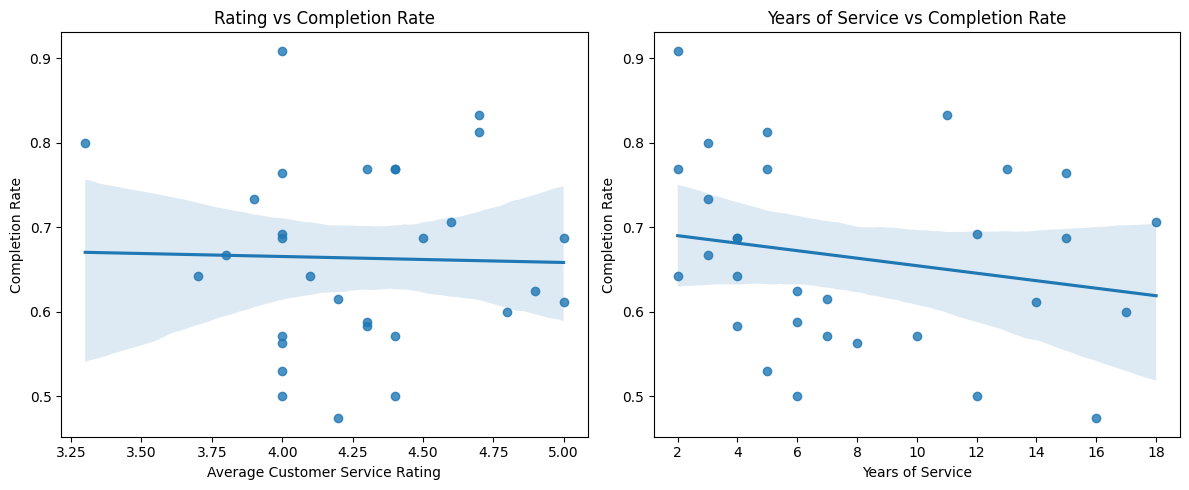

In [183]:
# Merge completion rate with agent ratings and years of service
correlation_df = completion_stats_sorted.merge(
    space_travel_agents_df[
        ["AgentID", "AverageCustomerServiceRating", "YearsOfService"]
    ],
    left_on="AgentName",
    right_on=space_travel_agents_df["FirstName"]
    + " "
    + space_travel_agents_df["LastName"],
    how="left",
)

# Correlation between AverageCustomerServiceRating and completion rate
rating_corr = correlation_df["AverageCustomerServiceRating"].corr(
    correlation_df["completion_rate"]
)
print(
    f"Correlation between AverageCustomerServiceRating and completion rate: {rating_corr:.3f}"
)

# Correlation between YearsOfService and completion rate
service_corr = correlation_df["YearsOfService"].corr(correlation_df["completion_rate"])
print(f"Correlation between YearsOfService and completion rate: {service_corr:.3f}")

# Scatter plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.regplot(
    x=correlation_df["AverageCustomerServiceRating"],
    y=correlation_df["completion_rate"],
)
plt.xlabel("Average Customer Service Rating")
plt.ylabel("Completion Rate")
plt.title("Rating vs Completion Rate")

plt.subplot(1, 2, 2)
sns.regplot(x=correlation_df["YearsOfService"], y=correlation_df["completion_rate"])
plt.xlabel("Years of Service")
plt.ylabel("Completion Rate")
plt.title("Years of Service vs Completion Rate")

plt.tight_layout()
plt.show()

In [184]:
# Calculate elapsed time to completion or cancellation
merged_df["CancelledDate"] = pd.to_datetime(merged_df["CancelledDate"])
merged_df["end_date"] = merged_df["BookingCompleteDate"].combine_first(
    merged_df["CancelledDate"]
)
merged_df["elapsed_time_hours_any"] = (
    merged_df["end_date"] - merged_df["AssignedDateTime"]
).dt.total_seconds() / 3600

# Only consider assignments with a valid end date
valid_time = merged_df[merged_df["end_date"].notnull()]

# Aggregate total time and total revenue per agent
agent_time_revenue = valid_time.groupby("AgentID").agg(
    total_time_hours=("elapsed_time_hours_any", "sum"),
    total_revenue=("TotalRevenue", "sum"),
)
agent_time_revenue = agent_time_revenue.merge(
    space_travel_agents_df[["AgentID", "FirstName", "LastName"]], on="AgentID"
)
agent_time_revenue["AgentName"] = (
    agent_time_revenue["FirstName"] + " " + agent_time_revenue["LastName"]
)
agent_time_revenue["revenue_per_hour"] = (
    agent_time_revenue["total_revenue"] / agent_time_revenue["total_time_hours"]
)

# Display sorted by revenue per hour
agent_time_revenue_sorted = agent_time_revenue[
    ["AgentName", "total_revenue", "total_time_hours", "revenue_per_hour"]
].sort_values("revenue_per_hour", ascending=False)
display(agent_time_revenue_sorted)

# Insights:
# The table above shows the total revenue, total time invested in hours, and revenue per hour for each agent.
# It is sorted by revenue per hour in descending order, highlighting the most efficient agents in terms of revenue generation relative to time spent.

,AgentName,total_revenue,total_time_hours,revenue_per_hour
27,Mila Reed,1830000.0,2.916667,627428.571429
17,Dax Reyes,2240000.0,3.750000,597333.333333
8,Luna Martinez,2135000.0,3.583333,595813.953488
1,Kai Rodriguez,2085000.0,3.583333,581860.465116
7,Orion Davis,1825000.0,3.833333,476086.956522
2,Nova Singh,2265000.0,4.833333,468620.689655
21,Juno Brooks,1790000.0,3.833333,466956.521739
3,Leo Kim,1950000.0,4.250000,458823.529412
11,Nia Ramirez,2165000.0,4.916667,440338.983051
23,Phoebe Diaz,1905000.0,4.416667,431320.754717


,total_destination_revenue,total_bookings,revenue_per_booking_average
Destination,,,
Mars,15465000.0,105,147285.714286
Titan,13075000.0,97,134793.814433
Venus,12530000.0,98,127857.142857
Europa,12260000.0,103,119029.126214
Ganymede,990000.0,9,110000.000000


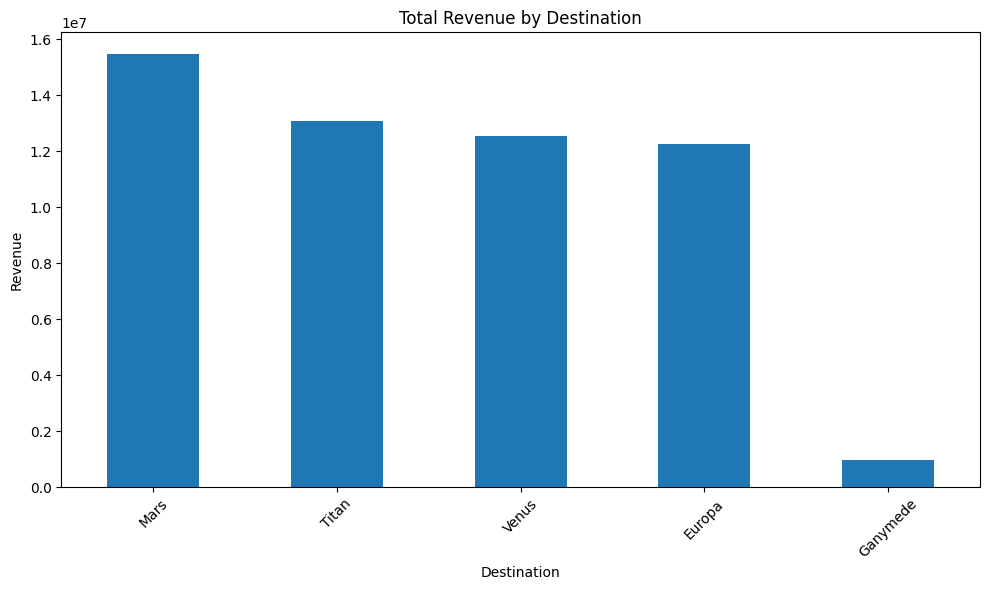

,total_launch_revenue,total_bookings,revenue_per_booking_average
LaunchLocation,,,
Dallas-Fort Worth Launch Complex,17775000.0,104,170913.461538
New York Orbital Gateway,15545000.0,101,153910.891089
Dubai Interplanetary Hub,15415000.0,101,152623.762376
Tokyo Spaceport Terminal,14065000.0,98,143520.408163
London Ascension Platform,1095000.0,7,156428.571429
Sydney Stellar Port,125000.0,1,125000.000000


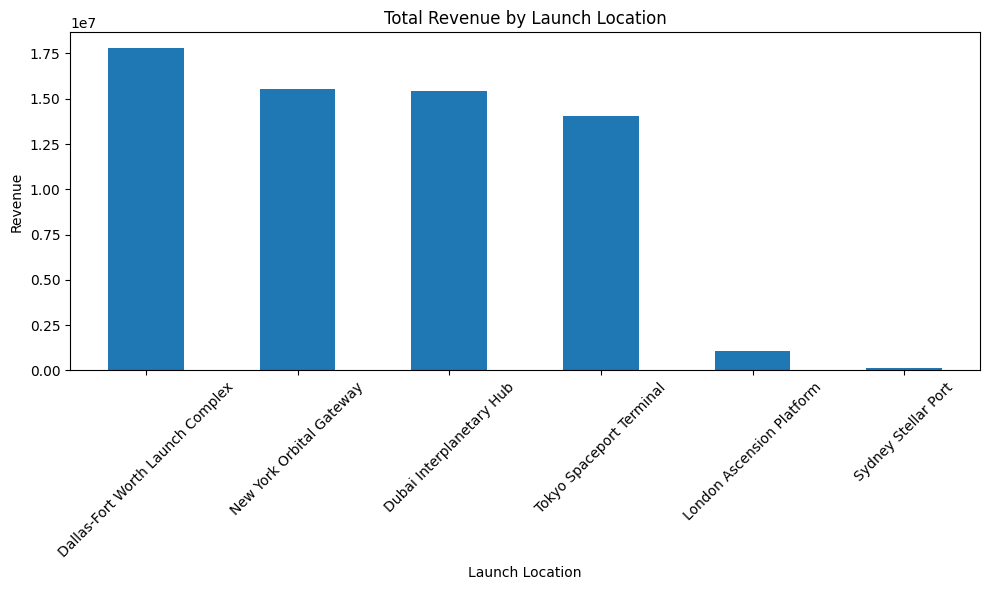

,total_package_revenue,total_bookings,revenue_per_booking_average
Package,,,
Luxury Dome Stay,2635000.0,105,25095.238095
Cloud City Excursion,2470000.0,98,25204.081633
Ringside Cruise,2270000.0,97,23402.061856
Zero-Gravity Yacht Cruise,1320000.0,65,20307.692308
Glacier Trek Adventure,830000.0,38,21842.105263
Private Observatory Suite,175000.0,9,19444.444444


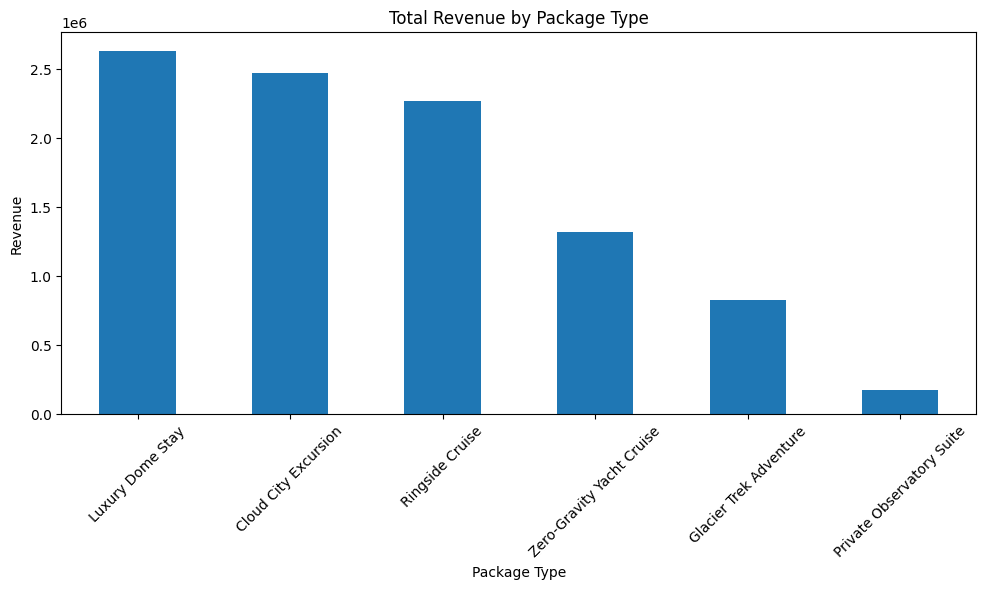

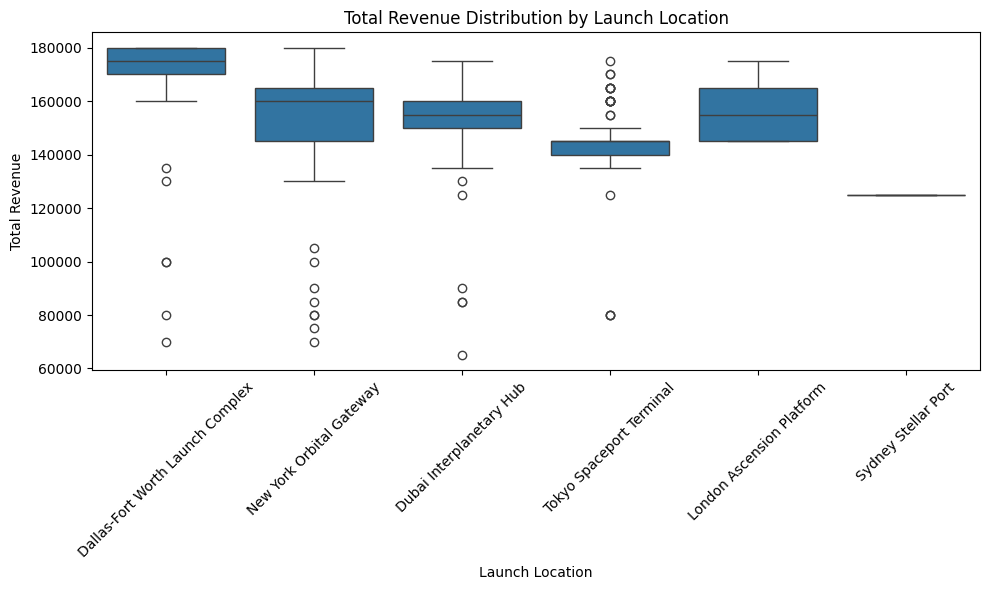

In [185]:
# Revenue by Destination
revenue_by_destination = merged_df.groupby("Destination").agg(
    total_destination_revenue=("DestinationRevenue", "sum"),
    total_bookings=("AssignmentID", "count"),
    revenue_per_booking_average=("DestinationRevenue", "mean"),
)
revenue_by_destination = revenue_by_destination.sort_values(
    "total_destination_revenue", ascending=False
)
display(revenue_by_destination)

plt.figure(figsize=(10, 6))
revenue_by_destination["total_destination_revenue"].plot(kind="bar")
plt.title("Total Revenue by Destination")
plt.ylabel("Revenue")
plt.xlabel("Destination")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Revenue by Launch Location
revenue_by_launch = merged_df.groupby("LaunchLocation").agg(
    total_launch_revenue=("TotalRevenue", "sum"),
    total_bookings=("AssignmentID", "count"),
    revenue_per_booking_average=("TotalRevenue", "mean"),
)
revenue_by_launch = revenue_by_launch.sort_values(
    "total_launch_revenue", ascending=False
)
display(revenue_by_launch)

plt.figure(figsize=(10, 6))
revenue_by_launch["total_launch_revenue"].plot(kind="bar")
plt.title("Total Revenue by Launch Location")
plt.ylabel("Revenue")
plt.xlabel("Launch Location")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Revenue by Package
revenue_by_package = merged_df.groupby("Package").agg(
    total_package_revenue=("PackageRevenue", "sum"),
    total_bookings=("AssignmentID", "count"),
    revenue_per_booking_average=("PackageRevenue", "mean"),
)
revenue_by_package = revenue_by_package.sort_values(
    "total_package_revenue", ascending=False
)
display(revenue_by_package)

plt.figure(figsize=(10, 6))
revenue_by_package["total_package_revenue"].plot(kind="bar")
plt.title("Total Revenue by Package Type")
plt.ylabel("Revenue")
plt.xlabel("Package Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Pair total revenue against launch location
plt.figure(figsize=(10, 6))
sns.boxplot(x=merged_df["LaunchLocation"], y=merged_df["TotalRevenue"])
plt.title("Total Revenue Distribution by Launch Location")
plt.ylabel("Total Revenue")
plt.xlabel("Launch Location")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [186]:
# Filter for non-cancelled bookings
non_cancelled = merged_df[merged_df["CancelledDate"].isnull()]

# Agent proficiency by LaunchLocation (weighted by revenue)
launch_agent_perf = non_cancelled.groupby(["LaunchLocation", "AgentID"]).agg(
    total_revenue=("TotalRevenue", "sum"),
    completed_bookings=("BookingCompleteDate", lambda x: x.notnull().sum()),
    total_assignments=("AssignmentID", "count"),
)
launch_agent_perf = launch_agent_perf.reset_index()
launch_agent_perf["completion_rate"] = (
    launch_agent_perf["completed_bookings"] / launch_agent_perf["total_assignments"]
)
launch_agent_perf = launch_agent_perf.merge(
    space_travel_agents_df[["AgentID", "FirstName", "LastName"]], on="AgentID"
)
launch_agent_perf["AgentName"] = (
    launch_agent_perf["FirstName"] + " " + launch_agent_perf["LastName"]
)

# Top agents per LaunchLocation by revenue
launch_top_agents = launch_agent_perf.sort_values(
    ["LaunchLocation", "total_revenue"], ascending=[True, False]
)

display(
    launch_top_agents.groupby("LaunchLocation").head(3)[
        [
            "LaunchLocation",
            "AgentName",
            "total_revenue",
            "completion_rate",
            "completed_bookings",
        ]
    ]
)

# Agent proficiency by Package (weighted by revenue)
package_agent_perf = non_cancelled.groupby(["Package", "AgentID"]).agg(
    total_revenue=("PackageRevenue", "sum"),
    completed_bookings=("BookingCompleteDate", lambda x: x.notnull().sum()),
    total_assignments=("AssignmentID", "count"),
)
package_agent_perf = package_agent_perf.reset_index()
package_agent_perf["completion_rate"] = (
    package_agent_perf["completed_bookings"] / package_agent_perf["total_assignments"]
)
package_agent_perf = package_agent_perf.merge(
    space_travel_agents_df[["AgentID", "FirstName", "LastName"]], on="AgentID"
)
package_agent_perf["AgentName"] = (
    package_agent_perf["FirstName"] + " " + package_agent_perf["LastName"]
)

# Top agents per Package by revenue
package_top_agents = package_agent_perf.sort_values(
    ["Package", "total_revenue"], ascending=[True, False]
)

display(
    package_top_agents.groupby("Package").head(3)[
        [
            "Package",
            "AgentName",
            "total_revenue",
            "completion_rate",
            "completed_bookings",
        ]
    ]
)

# Agent proficiency by Destination (weighted by revenue)
destination_agent_perf = non_cancelled.groupby(["Destination", "AgentID"]).agg(
    total_revenue=("DestinationRevenue", "sum"),
    completed_bookings=("BookingCompleteDate", lambda x: x.notnull().sum()),
    total_assignments=("AssignmentID", "count"),
)
destination_agent_perf = destination_agent_perf.reset_index()
destination_agent_perf["completion_rate"] = (
    destination_agent_perf["completed_bookings"]
    / destination_agent_perf["total_assignments"]
)
destination_agent_perf = destination_agent_perf.merge(
    space_travel_agents_df[["AgentID", "FirstName", "LastName"]], on="AgentID"
)
destination_agent_perf["AgentName"] = (
    destination_agent_perf["FirstName"] + " " + destination_agent_perf["LastName"]
)

# Top agents per Destination by revenue
destination_top_agents = destination_agent_perf.sort_values(
    ["Destination", "total_revenue"], ascending=[True, False]
)

display(
    destination_top_agents.groupby("Destination").head(3)[
        [
            "Destination",
            "AgentName",
            "total_revenue",
            "completion_rate",
            "completed_bookings",
        ]
    ]
)

,LaunchLocation,AgentName,total_revenue,completion_rate,completed_bookings
26,Dallas-Fort Worth Launch Complex,Mila Reed,1220000.0,1.000000,7
2,Dallas-Fort Worth Launch Complex,Nova Singh,875000.0,1.000000,5
12,Dallas-Fort Worth Launch Complex,Atlas Foster,715000.0,1.000000,4
42,Dubai Interplanetary Hub,Selene Ali,795000.0,0.600000,3
44,Dubai Interplanetary Hub,Zion Parker,785000.0,1.000000,5
52,Dubai Interplanetary Hub,Enzo Nguyen,635000.0,1.000000,4
58,London Ascension Platform,Zara Khan,175000.0,1.000000,1
62,London Ascension Platform,Juno Brooks,170000.0,1.000000,1
59,London Ascension Platform,Atlas Foster,160000.0,1.000000,1
79,New York Orbital Gateway,Dax Reyes,945000.0,0.666667,4


,Package,AgentName,total_revenue,completion_rate,completed_bookings
13,Cloud City Excursion,Selene Ali,145000.0,0.600000,3
15,Cloud City Excursion,Zion Parker,135000.0,1.000000,5
24,Cloud City Excursion,Enzo Nguyen,105000.0,1.000000,4
42,Glacier Trek Adventure,Dax Reyes,70000.0,0.666667,2
39,Glacier Trek Adventure,Nia Ramirez,65000.0,0.666667,2
30,Glacier Trek Adventure,Nova Singh,50000.0,1.000000,2
75,Luxury Dome Stay,Mila Reed,170000.0,1.000000,7
50,Luxury Dome Stay,Nova Singh,125000.0,1.000000,5
60,Luxury Dome Stay,Atlas Foster,115000.0,1.000000,4
82,Private Observatory Suite,Rhea Chen,45000.0,0.500000,1


,Destination,AgentName,total_revenue,completion_rate,completed_bookings
4,Europa,Soren Baker,720000.0,1.00,6
20,Europa,Cassian Ward,600000.0,1.00,5
15,Europa,Dax Reyes,485000.0,0.75,3
31,Ganymede,Rhea Chen,220000.0,0.50,1
27,Ganymede,Aurora Tanaka,110000.0,1.00,1
28,Ganymede,Leo Kim,110000.0,1.00,1
62,Mars,Mila Reed,1050000.0,1.00,7
37,Mars,Nova Singh,750000.0,1.00,5
36,Mars,Kai Rodriguez,600000.0,1.00,4
88,Titan,Ronan Young,630000.0,1.00,5


In [187]:
# Show all rows and columns in pandas output
display_opts = {
    "display.max_rows": None,
    "display.max_columns": None,
    "display.width": None,
    "display.max_colwidth": None,
}
for k, v in display_opts.items():
    pd.set_option(k, v)

# Completion rate and total count for each agent by CustomerName
customer_agent_perf = merged_df.groupby(["CustomerName", "AgentID"]).agg(
    completed_bookings=("BookingCompleteDate", lambda x: x.notnull().sum()),
    total_assignments=("AssignmentID", "count"),
)
customer_agent_perf = customer_agent_perf.reset_index()
customer_agent_perf["completion_rate"] = (
    customer_agent_perf["completed_bookings"] / customer_agent_perf["total_assignments"]
)
customer_agent_perf = customer_agent_perf.merge(
    space_travel_agents_df[["AgentID", "FirstName", "LastName"]], on="AgentID"
)
customer_agent_perf["AgentName"] = (
    customer_agent_perf["FirstName"] + " " + customer_agent_perf["LastName"]
)

# Sort by CustomerName and total_assignments descending, then completion_rate descending
sorted_customer_agent_perf = customer_agent_perf.sort_values(
    ["CustomerName", "total_assignments", "completion_rate"],
    ascending=[True, False, False],
)

display(
    sorted_customer_agent_perf[
        ["CustomerName", "AgentName", "completion_rate", "total_assignments"]
    ]
)

# Completion rate and total count for each agent by CommunicationMethod
comm_agent_perf = merged_df.groupby(["CommunicationMethod", "AgentID"]).agg(
    completed_bookings=("BookingCompleteDate", lambda x: x.notnull().sum()),
    total_assignments=("AssignmentID", "count"),
)
comm_agent_perf = comm_agent_perf.reset_index()
comm_agent_perf["completion_rate"] = (
    comm_agent_perf["completed_bookings"] / comm_agent_perf["total_assignments"]
)
comm_agent_perf = comm_agent_perf.merge(
    space_travel_agents_df[["AgentID", "FirstName", "LastName"]], on="AgentID"
)
comm_agent_perf["AgentName"] = (
    comm_agent_perf["FirstName"] + " " + comm_agent_perf["LastName"]
)

comm_agent_perf = comm_agent_perf.sort_values(
    ["CommunicationMethod", "total_assignments", "completion_rate"],
    ascending=[True, False, False],
)

display(
    comm_agent_perf[
        ["CommunicationMethod", "AgentName", "completion_rate", "total_assignments"]
    ]
)

# Completion rate and total count for each agent by LeadSource
lead_agent_perf = merged_df.groupby(["LeadSource", "AgentID"]).agg(
    completed_bookings=("BookingCompleteDate", lambda x: x.notnull().sum()),
    total_assignments=("AssignmentID", "count"),
)
lead_agent_perf = lead_agent_perf.reset_index()
lead_agent_perf["completion_rate"] = (
    lead_agent_perf["completed_bookings"] / lead_agent_perf["total_assignments"]
)
lead_agent_perf = lead_agent_perf.merge(
    space_travel_agents_df[["AgentID", "FirstName", "LastName"]], on="AgentID"
)
lead_agent_perf["AgentName"] = (
    lead_agent_perf["FirstName"] + " " + lead_agent_perf["LastName"]
)

lead_agent_perf = lead_agent_perf.sort_values(
    ["LeadSource", "total_assignments", "completion_rate"],
    ascending=[True, False, False],
)

display(
    lead_agent_perf[["LeadSource", "AgentName", "completion_rate", "total_assignments"]]
)

,CustomerName,AgentName,completion_rate,total_assignments
0,Adeline Scott,Juno Brooks,1.0,1
1,Adley Rivera,Calypso White,0.0,1
2,Adriel Rivera,Vega Price,1.0,1
3,Aiden Shaw,Kai Rodriguez,1.0,1
4,Alaia King,Vega Price,1.0,1
5,Alani King,Nia Ramirez,1.0,1
6,Alaric Brooks,Vega Price,1.0,1
7,Alayah Cruz,Lyra Morgan,1.0,1
8,Alayah Ross,Selene Ali,1.0,1
9,Alessia Cruz,Vera Nguyen,1.0,1


,CommunicationMethod,AgentName,completion_rate,total_assignments
2,Phone Call,Nova Singh,0.900000,10
10,Phone Call,Elias Walker,0.875000,8
13,Phone Call,Selene Ali,0.750000,8
14,Phone Call,Rhea Chen,0.500000,8
17,Phone Call,Dax Reyes,0.500000,8
24,Phone Call,Enzo Nguyen,0.857143,7
21,Phone Call,Juno Brooks,0.714286,7
27,Phone Call,Mila Reed,0.714286,7
5,Phone Call,Soren Baker,1.000000,6
6,Phone Call,Mira Patel,0.833333,6


,LeadSource,AgentName,completion_rate,total_assignments
16,Bought,Lyra Morgan,0.833333,12
18,Bought,Calypso White,0.750000,12
11,Bought,Nia Ramirez,0.666667,12
22,Bought,Cassian Ward,0.727273,11
2,Bought,Nova Singh,0.800000,10
1,Bought,Kai Rodriguez,0.500000,10
8,Bought,Luna Martinez,0.500000,10
12,Bought,Atlas Foster,0.500000,10
10,Bought,Elias Walker,0.777778,9
5,Bought,Soren Baker,0.666667,9
